In [1]:
import pandas as pd
import os
import csv
from tqdm import tqdm


In [2]:
from scipy import ndimage
from skimage import morphology
import matplotlib.pyplot as plt
import numpy as np
from pydicom import dcmread

In [ ]:
train= pd.read_csv("data/train/stage_2_train.csv")
train[['ID', 'Image', 'Diagnosis']] = train['ID'].str.split('_', expand=True)
train = train[['Image', 'Diagnosis', 'Label']]
train.drop_duplicates(inplace=True)
train = train.pivot(index='Image', columns='Diagnosis', values='Label').reset_index()
train['Image'] = 'ID_' + train['Image']
train.head()


In [ ]:
train.to_csv('data/train/stage_2_train_arranged.csv')

In [3]:
files = [os.path.splitext(filename)[0] for filename in os.listdir(path=r"data/1k_sample_data")] ##load list of name of images
sorty= pd.read_csv("data/train/stage_2_train_arranged.csv",index_col=0)
c=0
lst=[]
# lst2=[]
files=set(files)      #use set because it make loop suuuuupppeeeeeerrrr fast
# loop to get csv with 1000 images
# with tqdm(total=len(sorty.index)) as pbar:
#     for row in sorty.itertuples(index=False):
#         lst2.append(row) 
#         pbar.update(1) 
                
with tqdm(total=1000) as pbar:
    for row in sorty.itertuples(index=False):
        if(c==1000):
            break
        for d in files:
            if(row[0]==d):
                files.remove(d)
                lst.append(row)  
                c+=1
                pbar.update(1)
                break 
pa=pd.DataFrame(lst)
# pa.head()
print(c)
pa.head()
pa.to_csv('data/train/sampled_1000.csv')

100%|██████████| 752803/752803 [00:03<00:00, 233025.50it/s]


In [13]:
ds=dcmread("photo\ID_000039fa0.dcm")
y= pd.read_csv("data/train/sampled_1000.csv",index_col=0)
c=0;d=0;e=0;f=0;g=0;h=0;
for i,row in y.iterrows():
    if(row["epidural"]==1):
        c+=1
    elif(row["intraparenchymal"]==1):
        d+=1
    elif(row["intraventricular"]==1):
        e+=1
    elif(row["subarachnoid"]==1):
        f+=1
    elif(row["subdural"]==1):
        g+=1
    else:
        h+=1
print(c)

print(d)
print(e)
print(f)
print(g)
print(h)
print(c+d+e+f+g+h)


8
53
24
25
50
840
1000


In [3]:
ds=dcmread("data\\1k_sample_data\\ID_00b22a4bc.dcm")


In [5]:
from PIL import Image, ImageTk


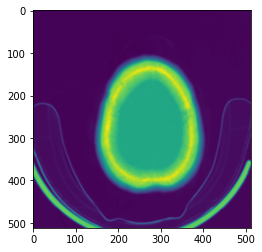

In [9]:
im = Image.fromarray(ds.pixel_array)
plt.imshow(im)

In [5]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [6]:
def resample(image, pixel_spacing):
    new_size = [1, 1]
    
    x_pixel = float(pixel_spacing[0])
    y_pixel = float(pixel_spacing[1])
    
    size = np.array([x_pixel, y_pixel])
    
    image_shape = np.array([image.shape[0], image.shape[1]])
    
    new_shape = image_shape * size
    new_shape = np.round(new_shape)
    resize_factor = new_shape / image_shape
    
    resampled_image = ndimage.zoom(image, resize_factor)
    
    return resampled_image

In [7]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept
    return hu_image


In [8]:
def crop_image(image, display=False):
    # Create a mask with the background pixels
    mask = image == 0

    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    
    # Remove the background
    croped_image = image[top_left[0]:bottom_right[0],
                top_left[1]:bottom_right[1]]
    
    return croped_image

In [9]:
def add_pad(image, new_height=275, new_width=275):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) // 2)
    pad_top = int((new_height - height) // 2)
    
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    
    return final_image

In [10]:

# sampled=resample(ds.pixel_array,ds.PixelSpacing)
# hu_image=transform_to_hu(ds,sampled)

# win_image=window_image(hu_image,300,2500)

# segmentation = morphology.dilation(win_image, np.ones((5, 5))) #dilation is used to fill with with given array when 1 is found
# segmentation[segmentation<0]=0
# labels, label_nb = ndimage.label(segmentation)   # label_nb are no of features and labels become array with feature indexes
# label_count = np.bincount(labels.ravel().astype(np.int64))  #bincount counts frequency of all pos no length=max element+1,  ravel() functions returns contiguous flattened array(1D array with all the input-array elements and with the same type as it
# label_count[0] = 0    #setting 0 or no pixel count to zero
# # label_count.argmax()
# mask =  labels==label_count.argmax()
# mask = ndimage.binary_fill_holes(mask)  #it fills holes in the mask by giving it max value
# mask = morphology.dilation(mask, np.ones((5, 5)))  
# masked_image =np.where(mask==1,win_image-win_image.min(),0)
# plt.imshow(masked_image,cmap='gray')
# print(masked_image.min())   

def remove_noise(image):
    segmentation = morphology.dilation(image, np.ones((5, 5))) #dilation is used to fill with with given array when 1 is found
    segmentation[segmentation<0]=0   # added later else mask appears empty sometime as pixel value comes negative

    labels, label_nb = ndimage.label(segmentation)   # label_nb are no of features and labels become array with feature indexes

    label_count = np.bincount(labels.ravel().astype(np.int64))  #bincount counts frequency of all pos no length=max element+1,  ravel() functions returns contiguous flattened array(1D array with all the input-array elements and with the same type as it
    label_count[0] = 0    #    # We don't use the first class since it's the background

    label_count.argmax()
    mask =  labels==label_count.argmax()
    mask = ndimage.binary_fill_holes(mask)  #it fills holes in the mask by giving it max value
    mask = morphology.dilation(mask, np.ones((3, 3)))  
   
    if(mask.sum()<14644):
        raise ValueError('Image too small to analyze')

    # masked_image = mask * image  #can't simply multiplya as window min value is less than 0
    masked_image =np.where(mask==1,image-image.min(),0)

    return masked_image


In [14]:
sampled=resample(ds.pixel_array,ds.PixelSpacing)
hu_image=transform_to_hu(ds,sampled)
win_image=window_image(hu_image,300,2500)
noise_removed=remove_noise(win_image)
cropped_image=crop_image(noise_removed)
padded_image=add_pad(cropped_image)
def preprocess(a,b,L,W):
    sampled=resample(a,b)
    hu_image=transform_to_hu(ds,sampled)
    win_image=window_image(hu_image,L,W)
    noise_removed=remove_noise(win_image)
    cropped_image=crop_image(noise_removed)
    padded_image=add_pad(cropped_image)
    return padded_image
# Width-Level
# 70,30 default brain window
# 2000,600 bone window
# 180,80 blood window
a=preprocess(ds.pixel_array,ds.PixelSpacing,30,70)
b=preprocess(ds.pixel_array,ds.PixelSpacing,600,2000)
c=preprocess(ds.pixel_array,ds.PixelSpacing,80,180)
d= np.array([a, b, c]).transpose(1,2,0)
# a.shape

(-0.5, 249.5, 249.5, -0.5)

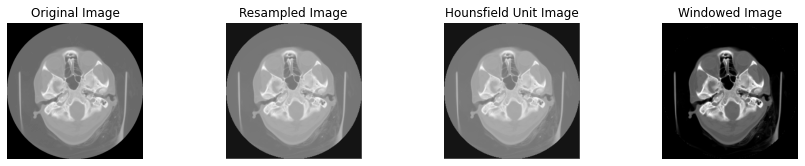

In [15]:
plt.figure(figsize=(15,2.5))
plt.subplot(141)
plt.imshow(ds.pixel_array,cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(142)
plt.imshow(sampled,cmap='gray')
plt.title("Resampled Image")
plt.axis('off')

plt.subplot(143)
plt.imshow(hu_image,cmap='gray')
plt.title("Hounsfield Unit Image")
plt.axis('off')

plt.subplot(144)
plt.imshow(win_image,cmap='gray')
plt.title("Windowed Image")
plt.axis('off')



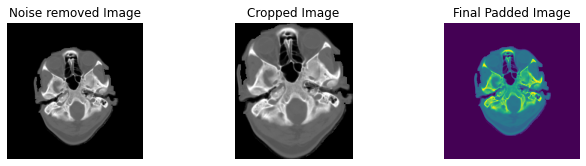

In [16]:
plt.figure(figsize=(15,2.5))
plt.subplot(141)
plt.imshow(noise_removed,cmap='gray')
plt.title("Noise removed Image")
plt.axis('off')

plt.subplot(142)
plt.imshow(cropped_image,cmap='gray')
plt.title("Cropped Image")
plt.axis('off')

plt.subplot(143)
plt.imshow(padded_image)
plt.title("Final Padded Image")
plt.axis('off')
plt.show()
plt.imsave('data\\temp\\'+'sf'+'.png', padded_image,cmap='gray')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 274.5, 274.5, -0.5)

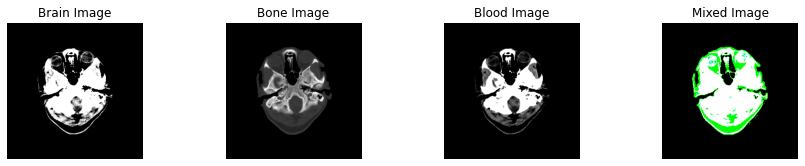

In [170]:
plt.figure(figsize=(15,2.5))
plt.subplot(141)
plt.imshow(a,cmap='gray')
plt.title("Brain Image")
plt.axis('off')

plt.subplot(142)
plt.imshow(b,cmap='gray')
plt.title("Bone Image")
plt.axis('off')

plt.subplot(143)
plt.imshow(c,cmap='gray')
plt.title("Blood Image")
plt.axis('off')

plt.subplot(144)
plt.imshow(d,cmap='gray')
plt.title("Mixed Image")
plt.axis('off')


In [5]:
import os
dir = os.path.join(os.getcwd(),"data","temp","brain_window")
if not os.path.exists(dir):
    os.makedirs(dir)
dir = os.path.join(os.getcwd(),"data","temp","bone_window")
if not os.path.exists(dir):
    os.makedirs(dir)
dir = os.path.join(os.getcwd(),"data","temp","blood_window")
if not os.path.exists(dir):
    os.makedirs(dir)

In [15]:
files = [os.path.basename(filename) for filename in os.listdir(path=r"data/1k_sample_data")] ##load list of name of images
i=[]
for d in files:
    try:
        SOURCE = "data\\1k_sample_data\\"
        BRAIN_DEST = "data\\temp\\brain_window\\"
        BONE_DEST = "data\\temp\\bone_window\\"
        BLOOD_DEST = "data\\temp\\blood_window\\"
        name = os.path.join(SOURCE, d)
        ds = dcmread(name)
        a = preprocess(ds.pixel_array, ds.PixelSpacing, 30, 70)
        b = preprocess(ds.pixel_array, ds.PixelSpacing, 600, 2000)
        c = preprocess(ds.pixel_array, ds.PixelSpacing, 80, 180)
        dname = d.split(".")[0]
        plt.imsave(BRAIN_DEST+dname+'.png', a, cmap='gray')
        plt.imsave(BONE_DEST+dname+'.png', b, cmap='gray')
        plt.imsave(BLOOD_DEST+dname+'.png', c, cmap='gray')
    except ValueError:
        i.append(d)


15407
15407
47089
15407
15407
47089
15407
15407
47089
28419
28419
62500
28419
28419
62500
28419
28419
62500
26069
26069
55696
26069
26069
55696
26069
26069
55696
29115
29115
50176
29115
29115
50176
29115
29115
50176
22960
22960
62500
22960
22960
62500
22960
22960
62500
22841
22841
62500
22841
22841
62500
22841
22841
62500
20882
20882
39204
20882
20882
39204
20882
20882
39204
11592
11592
64009
11241
11241
62500
24524
24524
62500
24524
24524
62500
24524
24524
62500
12694
12694
62500
13237
13237
62500
11722
11722
44100
5898
5898
62500
9461
9461
62500
26051
26051
50625
26051
26051
50625
26051
26051
50625
23122
23122
62500
23122
23122
62500
23122
23122
62500
20185
20185
49284
20185
20185
49284
20185
20185
49284
20915
20915
62500
20915
20915
62500
20915
20915
62500
22846
22846
46656
22846
22846
46656
22846
22846
46656
5890
5890
62500
21572
21572
62500
21572
21572
62500
21572
21572
62500
18801
18801
62500
18801
18801
62500
18801
18801
62500
24011
24011
51076
24011
24011
51076
24011
24011
5107

In [16]:
sorty= pd.read_csv("data/train/sampled_1000.csv",index_col=0)
i=list(i)
len(i)

237

In [70]:
sorty= pd.read_csv("data/train/sampled_1000.csv",index_col=0)
c=0
lst=[]
# i=set(i)      #use set because it make loop suuuuupppeeeeeerrrr fast
## loop to get csv with 1000 images
for j,row in sorty.iterrows():
    for d in i:
        if(row["Image"]==d.split('.')[0]):
            sorty.drop(sorty.loc[sorty['Image']==row['Image']].index,axis=0,inplace=True)
            c+=1
            break
sorty.to_csv('data/train/sampled_1000.csv')   
# pa.head()


In [71]:
len(sorty)
# 15752

986

In [71]:
sorty= pd.read_csv("data/model_history_log.csv")
sorty
epoch=[]
accuracy=[]
val_accuracy=[]
loss=[]
val_loss=[]
print(len(sorty.index))
with tqdm(total=len(sorty.index)) as pbar:
    for row in sorty.itertuples(index=False):
        epoch.append(row[0])  
        accuracy.append(row[1])
        val_accuracy.append(row[3])
        loss.append(row[2])
        val_loss.append(row[4])
        pbar.update(1)
                 

55


100%|██████████| 55/55 [00:00<00:00, 27501.99it/s]


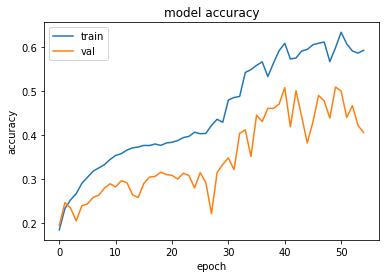

In [74]:

plt.plot(epoch,accuracy)
plt.plot(epoch,val_accuracy)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

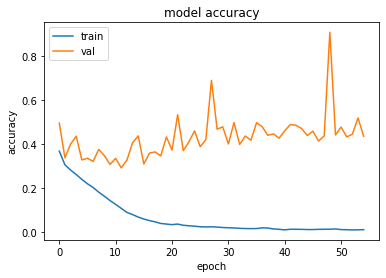

In [75]:
plt.plot(epoch,loss)
plt.plot(epoch,val_loss)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()